# Predict Customer Lifetime

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import shap

from lifelines import ExponentialFitter, GeneralizedGammaRegressionFitter
from lifelines import WeibullFitter, LogNormalFitter, LogLogisticFitter
from lifelines import LogNormalAFTFitter, LogLogisticAFTFitter, WeibullAFTFitter, CoxPHFitter

from lifelines.utils import concordance_index
from lifelines.plotting import qq_plot
from lifelines.utils import find_best_parametric_model

# import custom data class
from data.processing.processing import ChurnDataset

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# import churn dataset
data = ChurnDataset()
data.load_data()
# prepare dataset
data.prep_total_charges()
data.encode_numeric_features()
data.encode_categorical_features()
data.add_tenure_epsilon(epsilon=0.001)
# get prepared datasets
tenure_df = data.get_data()

In [3]:
tenure_df.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1.001,29,29,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,0,34.001,56,1889,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,2.001,53,108,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True


In [4]:
tenure_df.dtypes

SeniorCitizen                              int32
tenure                                   float64
MonthlyCharges                             int32
TotalCharges                               int32
gender_Male                                 bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             bool
TechSupport_Yes                             bool
StreamingTV_No inter

In [5]:
tenure_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.372149,64.295897,2282.830754
std,0.368612,24.559481,30.092727,2264.997388
min,0.000000,0.001000,18.000000,18.000000
25%,0.000000,9.001000,35.000000,401.500000
50%,0.000000,29.001000,70.000000,1400.000000
75%,0.000000,55.001000,89.000000,3786.500000
max,1.000000,72.001000,118.000000,8684.000000


# Exploratory Data Analysis

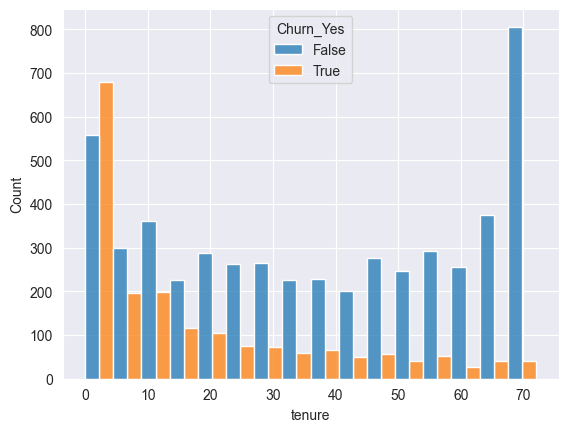

In [6]:
sns.histplot(
    data=tenure_df,
    x='tenure',
    hue='Churn_Yes',
    multiple='dodge')
plt.show()

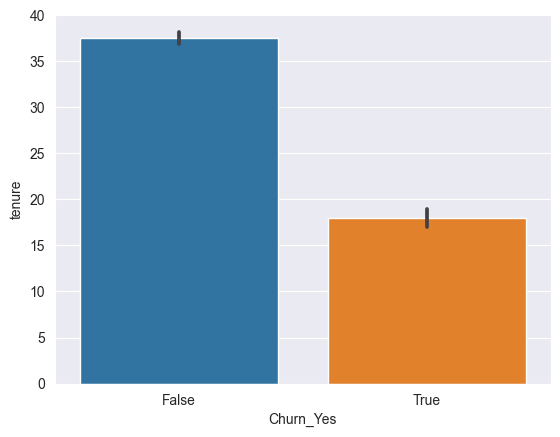

In [7]:
sns.barplot(
    data = tenure_df,
    y = 'tenure',
    x = 'Churn_Yes'   
)
plt.show()

# Train-Test Split

In [8]:
tenure_df_train, tenure_df_test = train_test_split(tenure_df, test_size=0.33, random_state=123)

In [9]:
tenure_df_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
3105,0,26.001,49,1237,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5195,0,72.001,75,5336,True,False,False,True,False,False,...,True,False,False,False,True,True,False,False,False,False
5748,0,21.001,99,1992,False,False,False,True,False,True,...,True,False,True,False,False,True,True,False,False,False
6988,0,23.001,69,1652,False,True,True,True,False,True,...,True,False,False,False,False,True,True,False,False,False
6523,0,15.001,45,693,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False


In [10]:
tenure_df_test.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
941,0,13.001,30,382,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1404,0,35.001,23,797,False,False,False,True,False,True,...,False,True,False,False,True,False,False,False,False,False
5515,0,18.001,19,309,False,True,True,True,False,False,...,False,True,False,False,True,False,False,False,True,False
3684,0,43.001,75,3161,True,False,False,True,False,True,...,False,False,False,False,False,True,True,False,False,False
7017,0,51.001,20,1020,False,False,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False


# Modeling 
## Regression Model for Lifetime Prediction (i.e. Tenure)

First let´s do "classical" machine learning the estimate the tenure values in the datasets of churners i.e. the uncensored data on which we can train a standard regression model

In [11]:
# get uncensored churn data to train regression model on
has_churned_train = tenure_df_train[tenure_df_train['Churn_Yes'] == 1]
has_churned_test = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]

has_churned_train.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
4556,0,2.001,67,116,True,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True
2589,1,3.001,76,231,True,False,False,True,False,True,...,False,False,False,False,False,True,False,True,False,True
6813,0,64.001,47,3147,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,True


In [12]:
features = has_churned_train.columns.to_list()
features.remove('TotalCharges') # this is leakage b/c its not known before churn
features.remove('Churn_Yes')
features.remove('tenure')
features

['SeniorCitizen',
 'MonthlyCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [13]:
X_train = has_churned_train[features]
y_train = has_churned_train['tenure'].values

In [14]:
X_test = has_churned_test[features]
y_test = has_churned_test['tenure'].values

In [15]:
y_train.shape

(1227,)

In [16]:
y_test.shape

(642,)

In [17]:
reg = GradientBoostingRegressor(random_state=123)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=123)

In [18]:
# r2 score on training set
r2_score(y_train, reg.predict(X_train))

0.6581366735491804

In [19]:
# r2 score on test set
r2_score(y_test, reg.predict(X_test))

0.543751791865825

In [20]:
# concordance index on training set
concordance_index(event_times=y_train, predicted_scores=reg.predict(X_train))

0.7964286620772899

In [21]:
# concordance index on test set
concordance_index(event_times=y_test, predicted_scores=reg.predict(X_test))

0.7666319546982908

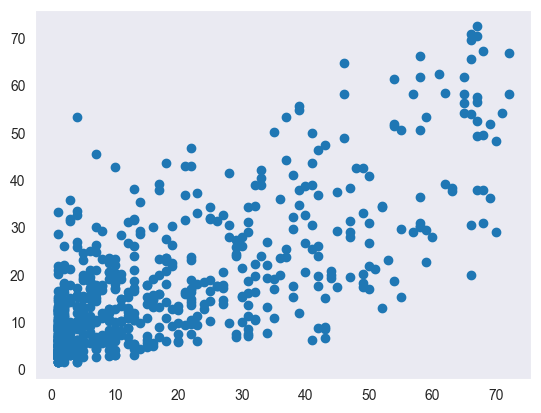

In [22]:
plt.scatter(
    x=y_test,
    y=reg.predict(X_test)
)
plt.grid()

## Feature Importance

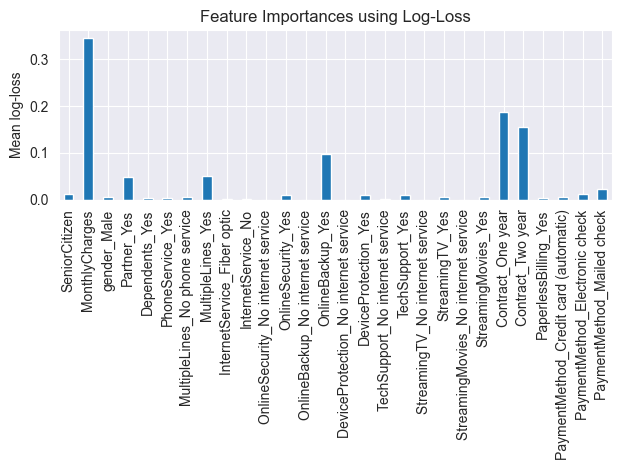

In [23]:
importances = reg.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()

## Conclusion
We cannot robustly predict tenure i.e. the number of month a customer will stay before churning beforehand; Let´s try to predict churn itself

## Classification Model for Churn-Prediction

In [24]:
features = tenure_df_train.columns.to_list()
features.remove('Churn_Yes')
features

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [25]:
X_train =  tenure_df_train[features]
y_train =  tenure_df_train['Churn_Yes'].values

In [26]:
X_test =  tenure_df_test[features]
y_test =  tenure_df_test['Churn_Yes'].values

In [27]:
clf = GradientBoostingClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [28]:
# accuracy score on training set
clf.score(X_train, y_train)

0.8281051292920729

In [29]:
# accuracy score on test set
clf.score(X_test, y_test)

0.7982795698924732

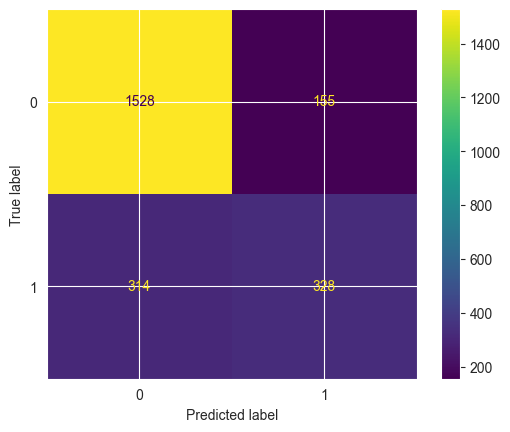

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

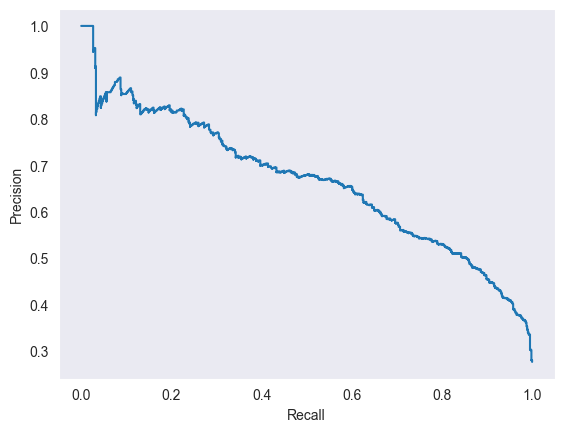

In [31]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

## Feature Importance

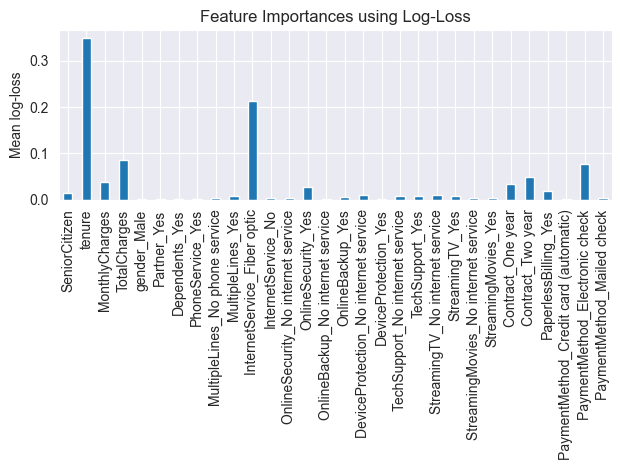

In [32]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()

In [33]:
explainer = shap.TreeExplainer(
    model=clf,
    data = X_test, 
    feature_perturbation = "interventional",
    model_output='probability')

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [ ]:
shap_values = explainer.shap_values(X_test, check_additivity=True)

In [ ]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='bar'
    )

In [ ]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='violin'
    )

In [ ]:
for f in data.numeric_features[:2]:
    fig, ax = plt.subplots(1,1)
    ax.grid()
    shap.dependence_plot(
        ind=f,
        shap_values=shap_values,
        features=X_test,
        interaction_index='auto',
        ax=ax
    )

# Survival Analysis
## Find best univariate model

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

T = tenure_df_train['tenure']
E = tenure_df_train['Churn_Yes']

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])

## Training Weibull Model

In [ ]:
import numpy as np
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score

class ChurnModels:
    def __init__(self):
        self.wb_aft_model = WeibullAFTFitter()
        self.cph_model = CoxPHFitter(penalizer=0.01)

    def fit(self, data:pd.DataFrame, duration_col:str, event_col:str, model_type:str):
        if model_type == 'WeibullAFT':
            self.wb_aft_model.fit(data, duration_col, event_col)
        elif model_type == 'CoxPH':
            self.cph_model.fit(data, duration_col, event_col)
        else:
            pass
    
    def summary(self, model_type:str):
        if model_type == 'WeibullAFT':
            return self.wb_aft_model.summary
        elif model_type == 'CoxPH':
            return self.cph_model.summary
        else:
            pass

    def predict_expected_lifetime(self, data:pd.DataFrame, model_type:str):
        if model_type == 'WeibullAFT':
            return self.wb_aft_model.predict_expectation(data)
        elif model_type == 'CoxPH':
            return self.cph_model.predict_expectation(data.drop(['tenure', 'Churn_Yes'], axis=1))
        else:
            pass
    
    def eval_concordance_index(self, event_times:pd.Series, event_predictions:pd.Series):
        "the r2 score should be best evaluated on uncensored subset of the data"
        return np.round(concordance_index(event_times, event_predictions), 2)
    
    def eval_r2_score(self, event_times:pd.Series, event_predictions:pd.Series):
        "the r2 score should be best evaluated on uncensored subset of the data"
        return np.round(r2_score(event_times, event_predictions), 2)

    


In [ ]:
# initialize model
models = ChurnModels()

# fit Weibull-ATF model on all i.e. right-censored data
models.fit(
    data=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    model_type='WeibullAFT')

# fit CoxPH model on all i.e. right-censored data
models.fit(
    data=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    model_type='CoxPH')

In [ ]:
# evaluate the models´ performance on uncensored data only
uncensored_data_train = tenure_df_train[tenure_df_train['Churn_Yes'] == 1]
uncensored_data_test = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]

In [ ]:
# Weibull Model: predict lifetimes on train and test sets
pred_train = models.predict_expected_lifetime(data=uncensored_data_train, model_type='WeibullAFT')
pred_test = models.predict_expected_lifetime(data=uncensored_data_test, model_type='WeibullAFT')

In [ ]:
# Weibull Model: get concordance score on test set for the weibull model
cindex_train = models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)
cindex_test = models.eval_concordance_index(uncensored_data_test['tenure'], pred_test)

print('Concordance index: train=', cindex_train)
print('Concordance index: test=', cindex_test)

In [ ]:
# Weibull Model: get r2 score on test set for the weibull model
r2score_train = models.eval_r2_score(uncensored_data_train['tenure'], pred_train)
r2score_test = models.eval_r2_score(uncensored_data_test['tenure'], pred_test)

print('R2-score: train=', r2score_train)
print('R2-score: test=', r2score_test)

In [ ]:
# Weibull Model: get summary statistics
models.summary(model_type='WeibullAFT')

In [ ]:
# CoxPh Model: predict lifetimes on train and test sets
pred_train = models.predict_expected_lifetime(data=uncensored_data_train, model_type='CoxPh')
pred_test = models.predict_expected_lifetime(data=uncensored_data_test, model_type='CoxPh')

In [ ]:
pred_train

In [ ]:
models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)

In [ ]:
# CoxPh Model: get concordance score on test set for the weibull model
cindex_train = models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)
cindex_test = models.eval_concordance_index(uncensored_data_test['tenure'], pred_test)

print('Concordance index: train=', cindex_train)
print('Concordance index: test=', cindex_test)

In [ ]:
# CoxPh Model: get summary statistics
models.summary(model_type='CoxPH')

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='gender_Male',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='SeniorCitizen',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='Partner_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='Dependents_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='PhoneService_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='MonthlyCharges',
    values=np.arange(0, 150, 30)
)
plt.title('Survival Curve')
plt.grid()
plt.show()

## Training Cox Proportional Hazard Model

In [ ]:
coxph = CoxPHFitter(penalizer=.01)
#coxph = CoxPHFitter(penalizer=0)

In [ ]:
coxph.fit(
    df=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    robust=False)

In [ ]:
coxph.summary

In [ ]:
coxph.baseline_hazard_.plot()
plt.show()

In [ ]:
coxph.baseline_survival_.plot()
plt.show()


In [ ]:
coxph.plot_partial_effects_on_outcome(
    covariates='MonthlyCharges',
    values=np.arange(0, 150, 30)
)
plt.title('Survival Curve')
plt.grid()
plt.show()

# Predict on Test Data

In [ ]:
tenure_df_test.head(3)

In [ ]:
has_churned = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]
has_churned.head(3)

In [ ]:
not_churned = tenure_df_test[tenure_df_test['Churn_Yes'] == 0]
not_churned.head(3)

In [ ]:
feat = list(has_churned.columns)
feat.remove('Churn_Yes')
feat.remove('tenure')
feat

In [ ]:
# predict tenure using Cox Proportional Hazard Model
pred_CPH = coxph.predict_median(
    X = has_churned[feat],
    conditional_after = None
    )

pred_CPH

In [ ]:
has_churned['tenure_prediction_WB'] = pred_WB
has_churned['tenure_prediction_CPH'] = pred_CPH


# replace the inf values of the coxprop model predictions with the max values
max_tennure_pred = has_churned['tenure_prediction_CPH'][has_churned['tenure_prediction_CPH'] != np.inf].max()
has_churned['tenure_prediction_CPH'].replace([np.inf, -np.inf], max_tennure_pred, inplace=True)

has_churned.head(10)

In [ ]:
# get r2 score on test set for the Cox Proportional Model
r2_score(has_churned['tenure'], has_churned['tenure_prediction_CPH'])

In [ ]:
sns.scatterplot(
    data=has_churned,
    x='tenure',
    y='tenure_prediction_WB'
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

In [ ]:
sns.scatterplot(
    data=has_churned,
    x='tenure',
    y='tenure_prediction_CPH'
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

# Survival Analysis using Scikit-Survival Package

In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv

In [ ]:
features = tenure_df_train.columns.to_list()
features.remove('tenure')
#features.remove('TotalCharges')
features.remove('Churn_Yes')
features

In [ ]:
X_train = tenure_df_train[features]
y_train = Surv.from_dataframe(
    event = 'Churn_Yes', 
    time = 'tenure', 
    data = tenure_df_train)

In [ ]:
X_test = tenure_df_test[features]
y_test = Surv.from_dataframe(
    event = 'Churn_Yes', 
    time = 'tenure', 
    data = tenure_df_test)

In [ ]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")
estimator.fit(X_train, y_train)

In [ ]:
# estimate the accuracy of the model i.e. the concordinance score
estimator.score(X_train, y_train)

In [ ]:
estimator.score(X_test, y_test)

In [ ]:
surv_funcs = estimator.predict_survival_function(X_train.iloc[:10])
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

## Predict Times to Event

In [ ]:
# predict tenure times
estimator = GradientBoostingSurvivalAnalysis(loss="squared")
estimator.fit(X_train, y_train) 


In [ ]:
estimator.score(X_train, y_train)

In [ ]:
estimator.score(X_test, y_test)

In [ ]:
time_to_event_pred = estimator.predict(X_test)

In [ ]:
sns.scatterplot(
    x=[tte for event, tte in y_test],
    y=time_to_event_pred
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

In [ ]:
# let´s just predict time-to-event on the uncensored dataset
index_uncensored = [i for i in range(len(y_test)) if y_test[i][0] == True]

In [ ]:
X_test.iloc[index_uncensored]

In [ ]:
y_test[index_uncensored]

In [ ]:
time_to_event_pred = estimator.predict(X_test.iloc[index_uncensored])

In [ ]:
sns.scatterplot(
    x=[tte for event, tte in y_test[index_uncensored]],
    y=time_to_event_pred
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

## Predict Time To Event for every Point in Time

In [ ]:
staged_time_to_event_pred = np.array([tte for tte in estimator.staged_predict(X_test)])

In [ ]:
time_to_event_pred[4]

In [ ]:
plt.plot(staged_time_to_event_pred[::-1,4])

# To Do

In [ ]:
# use further covariates in order for the cox model to converge
# upload local git repo to github
# compare model to normal regression model